# 3 Class 5CV LR_SVC_MNB_DT Words Stem + UpSampling (App 6)

## 1) Import Packages

In [1]:
### BASIC PACKAGES
import pandas as pd
import numpy as np

### SKLEARN'S MACHINE LEARNING MODELS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

### METRICS CALCULATION
from sklearn import metrics

### SPACY'S STOP WORDS
from spacy.lang.en.stop_words import STOP_WORDS

### NLTK STEMMER
from nltk.stem.snowball import SnowballStemmer

### VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
new_stop_words = list(STOP_WORDS)
new_stop_words.append("buy")
print(sorted(new_stop_words))

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'buy', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'h

## 2) ML with CV

In [3]:
# Pre-Processing:
# X = X or predictor variables, 1-D list or np.array
# y = y or target variables, 1-D list or np.array
# vect = CountVectorizer Text Preprocessor, needed for Text Analysis Machine Learning Model, CountVectorizer
# model = Machine Learning Model (E.g. Multinomial Naive Bayes, Linear SVC, LogisticRegression), sklearn ml model
# n_runs = Number of Runs to execute, int
# split_size = K fold Cross Validation, int
# print_itr = condition to print the iterations 

# Post-Processing:
# index = Index Labels of the data in the form of iter{iteration int}_cv_split{cv_split int}, list of int
# full_buy_words = list of lists of top 10 words in predicting label: "Buy", list of list of str
# full_sell_words = list of lists of top 10 words in predicting label: "Sell", list of list of str
# full_train_aucs = List of Areas Under Curve in predicting Training set data, list of float
# full_test_aucs = List of Areas Under Curve in predicting Testing set data, list of float
# full_train_accs = List of Accuracy Scores in predicting Training set data, list of float
# full_test_accs = List of Accuracy Scores in predicting Testing set data, list of float
# full_train_null_accs = List of Null Accuracy Scores in predicting Training set data, list of float
# full_test_null_accs = List of Null Accuracy Scores in predicting Testing set data, list of float
# full_test_conf_mats = Array of Confusion Matrix under the Test set, Numpy Array
# full_train_conf_mats = Array of Confusion Matrix under the Train set, Numpy Array

def ml_cv(X, y, vect, model, n_runs, split_size, print_itr):
    
    n_rows = len(y)

    ### RESULTS LISTS ###
    full_buy_words = []
    full_neut_words = []
    full_sell_words = []

    full_train_accs = []
    full_test_accs = []

    #full_train_aucs = []
    #full_test_aucs = []
    
    full_train_null_accs = []
    full_test_null_accs = []
    
    full_train_conf_mats = []
    full_test_conf_mats = []
    
    index = []
    
    classes = sorted(list(set(y)))
    
    class_pos_dict = {}
    all_pos_classes = []
    for c, ind in zip(classes, range(len(classes))):
        all_pos_classes.append([a for a in range(len(y)) if y[a] == c])
        class_pos_dict[c] = ind

    all_cv_splits_classes = []
    for c, all_pos_c in zip(classes, all_pos_classes):
        cv_splits_curr_c = [len(split_amts) for split_amts in np.array_split(list(range(len(all_pos_c))), split_size)]
        all_cv_splits_classes.append(cv_splits_curr_c)
    
    for i in range(n_runs):
        if(print_itr):
            print("Run: {curr_run} out of {n_runs}".format(curr_run = i+1, n_runs = n_runs))
        
        all_pos = range(len(y))
        
        all_cv_set_pos_classes = []
        for c in classes:
            all_cv_set_pos_classes.append([a for a in range(len(y)) if y[a] == c])
        
        for cv in range(split_size):
            if(print_itr):
                print("Cross Validation: {curr_split} out of {split_size}".format(curr_split = cv + 1, split_size = split_size))
            
            test_pos = []
            
            if cv == split_size - 1:
                for ls in all_cv_set_pos_classes:
                    test_pos = test_pos + ls
            else:
                all_test_pos_classes = []
                for c in classes:
                    all_test_pos_classes.append(list(np.random.choice(all_cv_set_pos_classes[class_pos_dict[c]], 
                                                                      size = all_cv_splits_classes[class_pos_dict[c]][cv], 
                                                                      replace=False)))
                for ls in all_test_pos_classes:
                    test_pos = test_pos + ls

            train_pos = list(set(all_pos) - set(test_pos))
            
            #print("train: ", train_pos, len(train_pos))
            #print("test: ", test_pos, len(test_pos))
            #print("Everything", list(set(train_pos + test_pos)), len(list(set(train_pos + test_pos))))
            
            X_train = [X[a] for a in train_pos]
            X_test = [X[a] for a in test_pos]
            y_train = [y[a] for a in train_pos]
            y_test = [y[a] for a in test_pos]
            
            update_cv_set_pos_classes = []
            for cv_ls, test_ls in zip(all_cv_set_pos_classes, all_test_pos_classes):
                update_cv_set_pos_classes.append(list(set(cv_ls) - set(test_ls)))
            #cv_set_pos_c0 = list(set(cv_set_pos_c0) - set(test_pos_c0))
            #cv_set_pos_c1 = list(set(cv_set_pos_c1) - set(test_pos_c1))
            
            ### UP SAMPLING AND SHUFFLING DONE HERE!!!
            X_train, y_train = up_samp_data(X_train, y_train)
            X_train, y_train = shuffle_data(X_train, y_train)
        
            X_test, y_test = up_samp_data(X_test, y_test)
            X_test, y_test = shuffle_data(X_test, y_test)
            
            all_cv_set_pos_classes = update_cv_set_pos_classes
            
            X_train_dtm = vect.fit_transform(X_train)
            X_test_dtm = vect.transform(X_test)

            model.fit(X_train_dtm, y_train)
            
            # PREDICTION ACCURACY SCORES
            y_pred_test_class = model.predict(X_test_dtm)
            y_pred_train_class = model.predict(X_train_dtm)
            
            train_acc_score = metrics.accuracy_score(y_pred=y_pred_train_class, y_true=y_train)
            test_acc_score = metrics.accuracy_score(y_pred=y_pred_test_class, y_true=y_test)
            
            full_train_accs.append(train_acc_score)
            full_test_accs.append(test_acc_score)
            
            # CONFUSION MATRIX
            full_train_conf_mats.append(metrics.confusion_matrix(y_true = y_train, y_pred = y_pred_train_class, labels = classes))
            full_test_conf_mats.append(metrics.confusion_matrix(y_true = y_test, y_pred = y_pred_test_class, labels = classes))
            
            # NULL ACCURACY SCORES
            train_classes = list(np.unique(y_train))
            test_classes = list(np.unique(y_test))
            
            train_most_occur_class = train_classes[1] if len([a for a in y_train if a == train_classes[1]])/len(y_train) >= 0.5 else train_classes[0]
            test_most_occur_class = test_classes[1] if len([a for a in y_test if a == test_classes[1]])/len(y_test) >= 0.5 else test_classes[0]
            
            train_null_acc = sum([1 for a in y_train if a == train_most_occur_class])/len(y_train)
            test_null_acc = sum([1 for a in y_test if a == test_most_occur_class])/len(y_test)
            
            full_train_null_accs.append(train_null_acc)
            full_test_null_accs.append(test_null_acc)
            
            # TOP 10 SELL, NEUTRAL AND BUY WORD PREDICTORS
            if 'coef_' in dir(model):
                #df = pd.DataFrame({'coef': model.coef_[0], 'word': vect.get_feature_names()})
                max_pos = [np.argmax(a) for a in model.coef_.transpose()]
                top_words_dicts = []
                for c in classes:
                    top_words_dicts.append({'coef': [], 'word': []})

                for coef_ls, word in zip(model.coef_.transpose(), vect.get_feature_names()):
                    top_words_dicts[np.argmax(coef_ls)]['coef'].append(np.max(coef_ls))
                    top_words_dicts[np.argmax(coef_ls)]['word'].append(word)
                
            elif 'feature_importances_' in dir(model):
                df = pd.DataFrame({'coef': model.feature_importances_, 'word': vect.get_feature_names()})
                
            
            sell_words_df = pd.DataFrame(top_words_dicts[0]).sort_values('coef', ascending=False)
            neut_words_df = pd.DataFrame(top_words_dicts[1]).sort_values('coef', ascending=False)
            buy_words_df = pd.DataFrame(top_words_dicts[2]).sort_values('coef', ascending=False)
            
            sell_words = list(sell_words_df.word[:10])
            neut_words = list(neut_words_df.word[:10])
            buy_words = list(buy_words_df.word[:10])

            full_sell_words.append(sell_words)
            full_neut_words.append(neut_words)
            full_buy_words.append(buy_words)
            
            # ITERATION AND SPLIT AS INDEXES
            curr_index = "iter{itr}_cv_split{cv_split}".format(itr = i + 1, cv_split = cv + 1)
            index.append(curr_index)
            
    return index, full_sell_words, full_neut_words, full_buy_words, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs, full_test_conf_mats, full_train_conf_mats


## 3) Stem All Tweets

In [4]:
### READ ALL TWEETS DATA
all_tweets = pd.read_csv('all_tweets_data.csv')

### STEM ALL TWEETS
stemmer = SnowballStemmer("english")
new_tweets_stem = []
for twt in all_tweets['new_tweets']:
    stem_words = [stemmer.stem(word) for word in twt.split(" ")]
    new_sentence = stem_words[0]
    for word in stem_words[1:]:
        new_sentence = new_sentence + " " + word
    new_tweets_stem.append(new_sentence)

### ADD NEWLY STEMMED TWEETS TO DF
all_tweets['new_tweets_stem'] = pd.Series(new_tweets_stem)
all_tweets

,X,Buy/Neutral/Sell,tweets,replies,retweets,favs,user,timeStamp,new_tweets,new_dts,assigned_member,coinMentioned,termsMentioned,new_tweets_stem
0,1,0,"<a href=""/hashtag/Substratum?src=hash"" data-qu...",88.0,376.0,807.0,officialmcafee,2018-02-02 13:19:00,alpha ii video w in this video you see just ho...,1.517549e+09,daryl,False,True,alpha ii video w in this video you see just ho...
1,2,0,"<a href=""https://t.co/WLJYQmRqOK"" rel=""nofollo...",156.0,72.0,215.0,officialmcafee,2018-02-02 10:37:00,price increase,1.517539e+09,daryl,False,True,price increas
2,3,0,Looking for a woman with ex SOF military exper...,416.0,206.0,1300.0,officialmcafee,2018-02-02 06:32:00,looking for a woman with ex sof military exper...,1.517524e+09,daryl,True,True,look for a woman with ex sof militari experi t...
3,5,1,"Coin Brothers - ""Buy the Fucking Dip""\n\n<a hr...",296.0,401.0,1300.0,officialmcafee,2018-02-02 04:19:00,coin brothers buy the fucking dip via,1.517516e+09,daryl,False,True,coin brother buy the fuck dip via
4,6,1,Lot's of people asking me over the past two da...,984.0,2100.0,6000.0,officialmcafee,2018-02-02 04:12:00,lot's of people asking me over the past two da...,1.517516e+09,daryl,True,True,lot of peopl ask me over the past two day whet...
5,8,0,Call for White papers: There are more than 50 ...,320.0,203.0,960.0,officialmcafee,2018-02-01 16:23:00,call for white papers there are more than new ...,1.517473e+09,daryl,False,True,call for white paper there are more than new i...
6,9,0,We are in a revolution against the waning powe...,1400.0,6400.0,15000.0,officialmcafee,2018-02-01 10:54:00,we are in a revolution against the waning powe...,1.517454e+09,daryl,True,True,we are in a revolut against the wane power of ...
7,11,0,Freelancers are 35% of the workforce. <a href=...,222.0,139.0,588.0,officialmcafee,2018-02-01 10:08:00,freelancers are of the workforce removes middl...,1.517451e+09,daryl,True,True,freelanc are of the workforc remov middlemen f...
8,14,0,"John McAfee Group Buy T-Shirt\n\n18,90 $ ! EU ...",57.0,45.0,169.0,officialmcafee,2018-01-30 13:04:00,john mcafee group buy tshirt eu amp usa free s...,1.517289e+09,daryl,True,True,john mcafe group buy tshirt eu amp usa free ship
9,16,1,"The <a href=""https://t.co/WLJYQmRqOK"" rel=""nof...",240.0,152.0,474.0,officialmcafee,2018-01-31 08:19:00,the ico is performing well the token price is ...,1.517358e+09,daryl,False,True,the ico is perform well the token price is go ...


## 4) Up-Sampling Tweets

For all the users, there is an imbalance in the tweet's signal types. Generally there are more "buy" signals as oppose to "sell" signals. Thus, we would want to upsample the "sell" signal which will help us perform 2 tasks. <br>

<ol>1. Balance the signal types of tweets for each user</ol>
<ol>2. Improve the learning ability of the models*</ol>

*It was observed that in approach 1 and 2, some models would plainly classify tweets to the most common class if not worst than the plain classifier. This would show that the learner has not effectively "learned" to classify tweets between both classes. This would explain why we received "information gain" <= 0. 

In [32]:
### Pre-Process
### X: Original Tweets as List
### y: Original Target as List

### Post-Process
### up_X: Up Sample Tweets as List
### up_y: Up Sample Targets as List

### Set the seed outside of this function so as not to always sample the way for each usage ###
### Up_samps for any different number of classes

def up_samp_data(X, y):
    classes = sorted(list(set(y)))
    class_val_counts = []
    for c in classes:
        count = 0
        for y_data in y:
            if y_data == c:
                count += 1
        class_val_counts.append(count)
    
    max_class_pos = 0
    max_class_size = class_val_counts[0]
    
    for c in range(len(classes)):
        if class_val_counts[c] > max_class_size:
            max_class_size = class_val_counts[c]
            max_class_pos = c
    
    up_X = list(X)
    up_y = list(y)
    
    for c in range(len(classes)):
        c_class = classes[c]
        if c != max_class_pos:
            min_class_pos_in_y = [pos for pos in range(len(up_y)) if up_y[pos] == c_class]

            up_samp_pos = np.random.randint(len(min_class_pos_in_y), size = class_val_counts[max_class_pos] - class_val_counts[c])

            for pos in up_samp_pos:
                up_X.append(up_X[min_class_pos_in_y[pos]])
                up_y.append(up_y[min_class_pos_in_y[pos]])

    return up_X, up_y

def shuffle_data(X, y):
    assert len(X) == len(y)
    shuffle_pos = np.arange(len(X))
    np.random.shuffle(shuffle_pos)
    return [X[pos] for pos in shuffle_pos], [y[pos] for pos in shuffle_pos]

In [13]:
### MAIN

def main_app6():
    all_users = all_tweets.user.unique()
    print(all_users)
    ### Iterate for all user's tweets with the exception for user 1 because he does not have a sell signal
    RES_FOLDER_PATH = "twt user results (3 class + stemmed + upsamp) app6"

    ### MODELS DICTIONARY
    lr = LogisticRegression(solver="lbfgs")
    svc = LinearSVC()
    nb = MultinomialNB()
    dt = DecisionTreeClassifier()

    model_dict = {
        'LogReg': lr,
        'LinSVC': svc,
        'MultiNB': nb
    }

    ### SAVE RESULTS
    for user_pos in range(1, len(all_tweets.user.unique())):

        np.random.seed(4222)

        user = all_tweets.user.unique()[user_pos]
        print(user)
        user_df = all_tweets[(all_tweets.user == user)]

        X, y = list(user_df.new_tweets_stem), list(user_df['Buy/Neutral/Sell'])

        for model_name in model_dict.keys():
            print(model_name)
            vect = CountVectorizer(stop_words=new_stop_words)
            model = model_dict[model_name]
            n_runs = 100
            split_size = 5
            print_itr = False

            index, full_sell_words, full_neut_words, full_buy_words, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs, full_test_conf_mats, full_train_conf_mats = ml_cv(X, y, vect, model, n_runs, split_size, print_itr)

            df_full_buy_words = pd.DataFrame(full_buy_words, index = index)
            df_full_buy_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_buy_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name))

            df_full_neut_words = pd.DataFrame(full_neut_words, index = index)
            df_full_neut_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_neut_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name))

            df_full_sell_words = pd.DataFrame(full_sell_words, index = index)
            df_full_sell_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_sell_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))

            #print(full_train_conf_mats[0])

            full_train_conf_mat_dict = {}
            for i in range(len(full_train_conf_mats[0])):
                for j in range(len(full_train_conf_mats[0][0])):
                    true_i_pred_j = []
                    for n_row in range(len(full_train_conf_mats)):
                        ind = "train_true_c{i}_pred_c{j}".format(i = i, j = j)
                        true_i_pred_j.append(full_train_conf_mats[n_row][i][j])
                    full_train_conf_mat_dict[ind] = true_i_pred_j

            full_test_conf_mat_dict = {}
            for i in range(len(full_test_conf_mats[0])):
                for j in range(len(full_test_conf_mats[0][0])):
                    true_i_pred_j = []
                    for n_row in range(len(full_test_conf_mats)):
                        ind = "test_true_c{i}_pred_c{j}".format(i = i, j = j)
                        true_i_pred_j.append(full_test_conf_mats[n_row][i][j])
                    full_test_conf_mat_dict[ind] = true_i_pred_j

            df_full_train_conf_mat = pd.DataFrame(full_train_conf_mat_dict, index = index)
            df_full_test_conf_mat = pd.DataFrame(full_test_conf_mat_dict, index = index)

            df_full_accs = pd.DataFrame({'full_train_accs': full_train_accs,
                                           'full_train_null_accs': full_train_null_accs,
                                           'full_test_accs': full_test_accs, 
                                           'full_test_null_accs': full_test_null_accs}, index = index)

            df_full_scores = pd.concat([df_full_accs, df_full_test_conf_mat, df_full_train_conf_mat], axis = 1)                                  

            df_full_scores.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))
            
%time main_app6()

['officialmcafee' 'CryptoYoda1338' 'ZeusZissou' 'anbessa100'
 'cryptousemaki']
CryptoYoda1338
LogReg
LinSVC
MultiNB
ZeusZissou
LogReg
LinSVC
MultiNB
anbessa100
LogReg
LinSVC
MultiNB
cryptousemaki
LogReg
LinSVC
MultiNB
Wall time: 6min 27s


In [7]:
user = all_tweets.user.unique()[1]
print(user)
user_df = all_tweets[(all_tweets.user == user)]
    
X, y = up_samp_data(user_df.new_tweets_stem, user_df['Buy/Neutral/Sell'])
X, y = shuffle_data(X, y)
vect = CountVectorizer(stop_words=new_stop_words)
model = LogisticRegression(multi_class='ovr', solver="lbfgs", fit_intercept=False)

X_dtm = vect.fit_transform(X)

model.fit(X_dtm, y)

df1 = pd.DataFrame({'coef': model.coef_[2], 'words': vect.get_feature_names()})
#print(df1.sort_values('coef', ascending=False)[1:10])
df2 = pd.DataFrame({'coef': model.coef_[0], 'words': vect.get_feature_names()})
#print(df2.sort_values('coef', ascending=True)[1:10])

def log_reg(x):
    return 1/(1+np.e**(-x))

#print(X_dtm[0].toarray()[0])

a = log_reg(np.dot(X_dtm[0].toarray()[0], model.coef_[0]) + model.intercept_[0])
b = log_reg(np.dot(X_dtm[0].toarray()[0], model.coef_[1]) + model.intercept_[1])
c = log_reg(np.dot(X_dtm[0].toarray()[0], model.coef_[2]) + model.intercept_[2])
res = [a, b, c]
res = res/sum(res)
#print(res)
#print(model.intercept_)
#print(model.predict_proba(X_dtm)[0])

max_pos = [np.argmax(a) for a in model.coef_.transpose()]
classes = [-1, 0, 1]
np.unique(max_pos)

top_words_dicts = []
for c in classes:
    top_words_dicts.append({'coef': [], 'word': []})
    
for coef_ls, word in zip(model.coef_.transpose(), vect.get_feature_names()):
    top_words_dicts[np.argmax(coef_ls)]['coef'].append(np.max(coef_ls))
    top_words_dicts[np.argmax(coef_ls)]['word'].append(word)

temp_df = pd.DataFrame(top_words_dicts[0])
print(temp_df.sort_values('coef', ascending=False)[:10])
temp_df = pd.DataFrame(top_words_dicts[1])
print(temp_df.sort_values('coef', ascending=False)[:10])
temp_df = pd.DataFrame(top_words_dicts[2])
print(temp_df.sort_values('coef', ascending=False)[:10])


CryptoYoda1338
         coef       word
69   1.313350      lower
19   1.224173      crash
67   1.187188        leg
59   1.092896    instead
77   1.084362       mind
17   0.935884    convinc
78   0.911510     mistak
12   0.858458     brutal
82   0.831284     outcom
127  0.831284  unsatisfi
         coef      word
202  1.639081    crypto
609  1.570095    observ
363  1.242995     futur
459  1.239773  interest
118  1.235291      btce
315  1.148757   everyth
95   1.109951   bitcoin
300  1.045566      epic
986  0.989228      wedg
958  0.957878        ur
         coef     word
171  1.233068     look
71   1.184413  develop
303  1.079676    upsid
304  1.045186  uptrend
263  0.993979     soon
73   0.985478    doubl
293  0.848482  trigger
197  0.848411  opinion
278  0.843078  technic
113  0.831074     folk


In [8]:
user = all_tweets.user.unique()[1]
print(user)
user_df = all_tweets[(all_tweets.user == user)]
    
X, y = up_samp_data(user_df.new_tweets_stem, user_df['Buy/Neutral/Sell'])
X, y = shuffle_data(X, y)
vect = CountVectorizer(stop_words=new_stop_words)
model = DecisionTreeClassifier()

X_dtm = vect.fit_transform(X)

model.fit(X_dtm, y)

model.feature_importances_
model.decision_path(X_dtm)

export_graphviz(model)

CryptoYoda1338


C:\Users\Daniel Chia\Anaconda3\lib\site-packages\sklearn\tree\export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


## 4) Visualization

We look at the performance of the 3 models by evaluating the box plots of the accuracy scores from the test sets and the Area Under Curve scores from the test sets.

In [15]:
# READ ALL THE DATA
model_names = ['LogReg', 'LinSVC', 'MultiNB']

res_dict = {}

all_users = all_tweets.user.unique()

RES_FOLDER_PATH = "twt user results (3 class + stemmed + upsamp) app6"

# Get all the scoring results
for model_name in model_names:
    mod_dict = {}
    for user in all_users[1:len(all_users)]:
        path = "./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH,user = user, model_name = model_name)
        res = pd.read_csv(path, index_col=0)
        mod_dict[user] = res
    res_dict[model_name] = mod_dict

In [17]:
# Types of Scores from the data
res_types = res_dict[model_name][user].columns
res_types

Index(['full_test_accs', 'full_test_null_accs', 'full_train_accs',
       'full_train_null_accs', 'test_true_c0_pred_c0', 'test_true_c0_pred_c1',
       'test_true_c0_pred_c2', 'test_true_c1_pred_c0', 'test_true_c1_pred_c1',
       'test_true_c1_pred_c2', 'test_true_c2_pred_c0', 'test_true_c2_pred_c1',
       'test_true_c2_pred_c2', 'train_true_c0_pred_c0',
       'train_true_c0_pred_c1', 'train_true_c0_pred_c2',
       'train_true_c1_pred_c0', 'train_true_c1_pred_c1',
       'train_true_c1_pred_c2', 'train_true_c2_pred_c0',
       'train_true_c2_pred_c1', 'train_true_c2_pred_c2'],
      dtype='object')

In [18]:
### helper function to extract all of the possible info
def get_model_all_user_scores(mod_dict, res_type):
    all_user_scores_dict = {}
    for user in mod_dict.keys():
        all_user_scores_dict[user] = mod_dict[user][res_type]
    
    df_all_user_scores = pd.DataFrame(all_user_scores_dict)
    
    return df_all_user_scores

### Combine scores of all users and models
def get_all_scores(res_dict, res_type):
    df_res = pd.DataFrame()
    for model in res_dict.keys():
        df_model = get_model_all_user_scores(res_dict[model], res_type)
        df_model = df_model.reset_index()
        df_model['model'] = pd.Series([model] * len(df_model))
        df_res = df_res.append(df_model)
    df_res = df_res.reset_index()
    df_res = df_res.drop('level_0', axis = 1)
    return df_res

In [19]:
### transform conf mat in ovr format
### return to binary classification, expecting 3 forms of conf mat
def make_ovr_conf_mat(conf_mat):
    num_class = conf_mat.shape[0]
    res_ovr_conf_mat = []
    for c in range(num_class):
        t_curr_p_curr, t_curr_p_oppo, t_oppo_p_curr, t_oppo_p_oppo = 0, 0, 0, 0
        t_curr_p_curr = conf_mat[c][c]
        for oppo in range(num_class):
            if oppo != c:
                t_curr_p_oppo = t_curr_p_oppo + conf_mat[c][oppo]
                t_oppo_p_curr = t_oppo_p_curr + conf_mat[oppo][c]
                for next_oppo in range(num_class):
                    if next_oppo != c:
                        t_oppo_p_oppo = t_oppo_p_oppo + conf_mat[oppo][next_oppo]
        res_ovr_conf_mat.append([[t_curr_p_curr, t_curr_p_oppo],[t_oppo_p_curr, t_oppo_p_oppo]])
    return res_ovr_conf_mat


### conf mat
for model in res_dict.keys():
    for user in res_dict[model].keys():
        for c0c0, c0c1, c0c2, c1c0, c1c1, c1c2, c2c0, c2c1, c2c2 in zip(res_dict[model][user]['test_true_c0_pred_c0'],
            res_dict[model][user]['test_true_c0_pred_c1'],
            res_dict[model][user]['test_true_c0_pred_c2'],
            res_dict[model][user]['test_true_c1_pred_c0'],
            res_dict[model][user]['test_true_c1_pred_c1'],
            res_dict[model][user]['test_true_c1_pred_c2'],
            res_dict[model][user]['test_true_c2_pred_c0'],
            res_dict[model][user]['test_true_c2_pred_c1'],
            res_dict[model][user]['test_true_c2_pred_c2']
        ):
        
            curr_conf_mat = np.array([c0c0, c0c1, c0c2, c1c0, c1c1, c1c2, c2c0, c2c1, c2c2]).reshape(3, 3)
            print(make_ovr_conf_mat(curr_conf_mat))
            

[[[0, 27], [1, 146]], [[84, 26], [42, 22]], [[16, 21], [31, 106]]]
[[[0, 27], [0, 147]], [[96, 14], [49, 15]], [[10, 27], [19, 118]]]
[[[0, 26], [0, 145]], [[90, 18], [38, 25]], [[18, 19], [25, 109]]]
[[[4, 21], [1, 145]], [[93, 16], [36, 26]], [[15, 22], [22, 112]]]
[[[0, 26], [0, 145]], [[96, 13], [38, 24]], [[24, 12], [13, 122]]]
[[[0, 27], [0, 147]], [[100, 10], [35, 29]], [[15, 22], [24, 113]]]
[[[0, 27], [2, 145]], [[96, 14], [37, 27]], [[13, 24], [26, 111]]]
[[[4, 22], [0, 145]], [[92, 16], [33, 30]], [[19, 18], [23, 111]]]
[[[0, 25], [0, 146]], [[93, 16], [44, 18]], [[18, 19], [16, 118]]]
[[[0, 26], [0, 145]], [[97, 12], [37, 25]], [[19, 17], [18, 117]]]
[[[0, 27], [0, 147]], [[98, 12], [39, 25]], [[20, 17], [17, 120]]]
[[[8, 19], [0, 147]], [[87, 23], [33, 31]], [[21, 16], [25, 112]]]
[[[0, 26], [0, 145]], [[100, 8], [41, 22]], [[14, 23], [16, 118]]]
[[[0, 25], [1, 145]], [[94, 15], [33, 29]], [[16, 21], [27, 107]]]
[[[0, 26], [0, 145]], [[89, 20], [46, 16]], [[16, 20], [20, 1

[[[4, 22], [0, 145]], [[97, 11], [35, 28]], [[17, 20], [18, 116]]]
[[[0, 25], [2, 144]], [[85, 24], [36, 26]], [[22, 15], [26, 108]]]
[[[0, 26], [0, 145]], [[104, 5], [32, 30]], [[15, 21], [20, 115]]]
[[[0, 27], [0, 147]], [[93, 17], [40, 24]], [[20, 17], [21, 116]]]
[[[13, 14], [1, 146]], [[95, 15], [32, 32]], [[17, 20], [16, 121]]]
[[[0, 26], [1, 144]], [[93, 15], [30, 33]], [[18, 19], [29, 105]]]
[[[3, 22], [0, 146]], [[92, 17], [45, 17]], [[14, 23], [17, 117]]]
[[[0, 26], [0, 145]], [[89, 20], [41, 21]], [[18, 18], [23, 112]]]
[[[0, 27], [1, 146]], [[102, 8], [39, 25]], [[14, 23], [18, 119]]]
[[[5, 22], [4, 143]], [[84, 26], [37, 27]], [[15, 22], [29, 108]]]
[[[0, 26], [4, 141]], [[95, 13], [29, 34]], [[17, 20], [26, 108]]]
[[[0, 25], [0, 146]], [[82, 27], [32, 30]], [[17, 20], [40, 94]]]
[[[0, 26], [1, 144]], [[98, 11], [39, 23]], [[15, 21], [18, 117]]]
[[[0, 27], [4, 143]], [[89, 21], [41, 23]], [[21, 16], [19, 118]]]
[[[5, 22], [1, 146]], [[99, 11], [36, 28]], [[19, 18], [14, 12

[[[0, 26], [0, 145]], [[93, 16], [39, 23]], [[16, 20], [23, 112]]]
[[[0, 27], [1, 146]], [[96, 14], [38, 26]], [[15, 22], [24, 113]]]
[[[0, 27], [3, 144]], [[91, 19], [29, 35]], [[22, 15], [29, 108]]]
[[[4, 22], [0, 145]], [[105, 3], [46, 17]], [[13, 24], [3, 131]]]
[[[0, 25], [1, 145]], [[99, 10], [41, 21]], [[20, 17], [10, 124]]]
[[[0, 26], [0, 145]], [[89, 20], [30, 32]], [[17, 19], [35, 100]]]
[[[0, 27], [1, 146]], [[100, 10], [43, 21]], [[15, 22], [15, 122]]]
[[[0, 27], [4, 143]], [[89, 21], [32, 32]], [[20, 17], [29, 108]]]
[[[3, 23], [0, 145]], [[94, 14], [38, 25]], [[18, 19], [18, 116]]]
[[[0, 25], [0, 146]], [[106, 3], [36, 26]], [[16, 21], [13, 121]]]
[[[0, 26], [0, 145]], [[84, 25], [33, 29]], [[16, 20], [38, 97]]]
[[[0, 27], [1, 146]], [[103, 7], [47, 17]], [[16, 21], [7, 130]]]
[[[0, 27], [2, 145]], [[99, 11], [29, 35]], [[18, 19], [26, 111]]]
[[[0, 26], [1, 144]], [[102, 6], [35, 28]], [[16, 21], [17, 117]]]
[[[0, 25], [0, 146]], [[99, 10], [37, 25]], [[21, 16], [14, 120]

[[[0, 27], [1, 146]], [[92, 18], [35, 29]], [[19, 18], [27, 110]]]
[[[8, 18], [0, 145]], [[94, 14], [25, 38]], [[23, 14], [21, 113]]]
[[[0, 25], [0, 146]], [[94, 15], [50, 12]], [[12, 25], [15, 119]]]
[[[4, 22], [0, 145]], [[98, 11], [41, 21]], [[10, 26], [18, 117]]]
[[[0, 27], [1, 146]], [[106, 4], [39, 25]], [[15, 22], [13, 124]]]
[[[0, 27], [0, 147]], [[104, 6], [41, 23]], [[15, 22], [14, 123]]]
[[[0, 26], [0, 145]], [[95, 13], [39, 24]], [[18, 19], [19, 115]]]
[[[0, 25], [0, 146]], [[93, 16], [35, 27]], [[22, 15], [21, 113]]]
[[[0, 26], [2, 143]], [[86, 23], [47, 15]], [[15, 21], [21, 114]]]
[[[0, 27], [2, 145]], [[98, 12], [38, 26]], [[18, 19], [18, 119]]]
[[[0, 27], [0, 147]], [[104, 6], [40, 24]], [[21, 16], [9, 128]]]
[[[7, 19], [1, 144]], [[96, 12], [39, 24]], [[16, 21], [12, 122]]]
[[[0, 25], [4, 142]], [[93, 16], [42, 20]], [[15, 22], [17, 117]]]
[[[0, 26], [0, 145]], [[91, 18], [27, 35]], [[15, 21], [38, 97]]]
[[[9, 18], [0, 147]], [[94, 16], [25, 39]], [[20, 17], [26, 111]

[[[3, 22], [0, 146]], [[97, 12], [46, 16]], [[13, 24], [12, 122]]]
[[[0, 26], [1, 144]], [[103, 6], [36, 26]], [[18, 18], [13, 122]]]
[[[0, 27], [4, 143]], [[101, 9], [42, 22]], [[22, 15], [5, 132]]]
[[[0, 27], [0, 147]], [[95, 15], [40, 24]], [[13, 24], [26, 111]]]
[[[0, 26], [1, 144]], [[98, 10], [29, 34]], [[22, 15], [21, 113]]]
[[[0, 25], [5, 141]], [[92, 17], [43, 19]], [[16, 21], [15, 119]]]
[[[6, 20], [2, 143]], [[91, 18], [32, 30]], [[18, 18], [22, 113]]]
[[[0, 27], [4, 143]], [[81, 29], [50, 14]], [[13, 24], [26, 111]]]
[[[8, 19], [3, 144]], [[104, 6], [36, 28]], [[15, 22], [8, 129]]]
[[[0, 26], [1, 144]], [[86, 22], [42, 21]], [[14, 23], [28, 106]]]
[[[0, 25], [0, 146]], [[99, 10], [37, 25]], [[21, 16], [14, 120]]]
[[[0, 26], [0, 145]], [[96, 13], [38, 24]], [[16, 20], [21, 114]]]
[[[0, 43], [1, 142]], [[118, 2], [61, 5]], [[5, 18], [1, 162]]]
[[[0, 42], [0, 141]], [[113, 5], [62, 3]], [[3, 20], [5, 155]]]
[[[0, 42], [5, 136]], [[110, 8], [52, 13]], [[4, 19], [12, 148]]]
[[[0

[[[0, 42], [0, 141]], [[115, 4], [62, 2]], [[2, 20], [4, 157]]]
[[[0, 43], [0, 143]], [[117, 3], [60, 6]], [[6, 17], [3, 160]]]
[[[0, 42], [0, 141]], [[113, 5], [61, 4]], [[4, 19], [5, 155]]]
[[[0, 42], [0, 141]], [[115, 3], [61, 4]], [[4, 19], [3, 157]]]
[[[0, 41], [0, 142]], [[114, 5], [60, 4]], [[4, 19], [5, 155]]]
[[[0, 42], [0, 141]], [[112, 7], [63, 1]], [[1, 21], [7, 154]]]
[[[0, 43], [3, 140]], [[115, 5], [63, 3]], [[3, 20], [2, 161]]]
[[[0, 42], [0, 141]], [[114, 4], [60, 5]], [[5, 18], [4, 156]]]
[[[0, 42], [0, 141]], [[112, 6], [61, 4]], [[4, 19], [6, 154]]]
[[[0, 41], [0, 142]], [[115, 4], [62, 2]], [[2, 21], [4, 156]]]
[[[0, 42], [2, 139]], [[117, 2], [58, 6]], [[6, 16], [0, 161]]]
[[[0, 43], [0, 143]], [[116, 4], [57, 9]], [[3, 20], [10, 153]]]
[[[0, 42], [3, 138]], [[115, 3], [59, 6]], [[6, 17], [0, 160]]]
[[[0, 42], [0, 141]], [[116, 2], [61, 4]], [[4, 19], [2, 158]]]
[[[0, 41], [1, 141]], [[110, 9], [59, 5]], [[5, 18], [8, 152]]]
[[[0, 42], [2, 139]], [[105, 14], [60, 

[[[0, 42], [3, 138]], [[106, 12], [59, 6]], [[6, 17], [9, 151]]]
[[[0, 42], [4, 137]], [[111, 7], [61, 4]], [[4, 19], [3, 157]]]
[[[0, 41], [0, 142]], [[108, 11], [60, 4]], [[4, 19], [11, 149]]]
[[[0, 42], [0, 141]], [[113, 6], [62, 2]], [[2, 20], [6, 155]]]
[[[0, 43], [0, 143]], [[119, 1], [62, 4]], [[4, 19], [1, 162]]]
[[[0, 42], [0, 141]], [[114, 4], [62, 3]], [[3, 20], [4, 156]]]
[[[0, 42], [0, 141]], [[116, 2], [46, 19]], [[4, 19], [17, 143]]]
[[[0, 41], [5, 137]], [[107, 12], [59, 5]], [[5, 18], [7, 153]]]
[[[0, 42], [0, 141]], [[112, 7], [45, 19]], [[4, 18], [22, 139]]]
[[[0, 43], [0, 143]], [[115, 5], [48, 18]], [[6, 17], [17, 146]]]
[[[0, 42], [0, 141]], [[114, 4], [62, 3]], [[3, 20], [4, 156]]]
[[[0, 42], [2, 139]], [[114, 4], [63, 2]], [[2, 21], [2, 158]]]
[[[0, 41], [1, 141]], [[115, 4], [61, 3]], [[3, 20], [3, 157]]]
[[[0, 42], [0, 141]], [[115, 4], [59, 5]], [[5, 17], [4, 157]]]
[[[0, 43], [0, 143]], [[117, 3], [49, 17]], [[3, 20], [17, 146]]]
[[[0, 42], [2, 139]], [[112,

[[[0, 42], [2, 139]], [[106, 12], [57, 8]], [[1, 22], [17, 143]]]
[[[11, 30], [0, 142]], [[115, 4], [52, 12]], [[1, 22], [4, 156]]]
[[[0, 42], [0, 141]], [[117, 2], [57, 7]], [[7, 15], [2, 159]]]
[[[0, 43], [0, 143]], [[111, 9], [59, 7]], [[7, 16], [9, 154]]]
[[[0, 42], [5, 136]], [[105, 13], [62, 3]], [[3, 20], [8, 152]]]
[[[0, 42], [0, 141]], [[106, 12], [58, 7]], [[7, 16], [12, 148]]]
[[[0, 41], [1, 141]], [[114, 5], [63, 1]], [[1, 22], [4, 156]]]
[[[0, 42], [0, 141]], [[116, 3], [62, 2]], [[2, 20], [3, 158]]]
[[[0, 43], [0, 143]], [[115, 5], [62, 4]], [[4, 19], [5, 158]]]
[[[0, 42], [3, 138]], [[102, 16], [64, 1]], [[1, 22], [13, 147]]]
[[[0, 42], [0, 141]], [[117, 1], [62, 3]], [[3, 20], [1, 159]]]
[[[0, 41], [0, 142]], [[118, 1], [60, 4]], [[4, 19], [1, 159]]]
[[[0, 42], [0, 141]], [[118, 1], [59, 5]], [[5, 17], [1, 160]]]
[[[0, 43], [0, 143]], [[112, 8], [64, 2]], [[2, 21], [8, 155]]]
[[[0, 42], [0, 141]], [[116, 2], [62, 3]], [[3, 20], [2, 158]]]
[[[10, 32], [0, 141]], [[117, 1

[[[0, 41], [0, 142]], [[111, 8], [59, 5]], [[5, 18], [8, 152]]]
[[[0, 42], [0, 141]], [[117, 2], [59, 5]], [[5, 17], [2, 159]]]
[[[0, 43], [0, 143]], [[108, 12], [60, 6]], [[6, 17], [12, 151]]]
[[[0, 42], [0, 141]], [[114, 4], [51, 14]], [[3, 20], [15, 145]]]
[[[0, 42], [0, 141]], [[117, 1], [63, 2]], [[2, 21], [1, 159]]]
[[[0, 41], [0, 142]], [[119, 0], [58, 6]], [[6, 17], [0, 160]]]
[[[0, 42], [2, 139]], [[113, 6], [60, 4]], [[4, 18], [4, 157]]]
[[[0, 35], [5, 131]], [[94, 15], [46, 16]], [[7, 20], [19, 125]]]
[[[9, 27], [2, 133]], [[100, 9], [43, 19]], [[3, 23], [14, 131]]]
[[[22, 14], [4, 131]], [[103, 6], [39, 23]], [[1, 25], [2, 143]]]
[[[0, 36], [2, 133]], [[96, 13], [48, 14]], [[7, 19], [18, 127]]]
[[[5, 30], [2, 131]], [[100, 7], [49, 12]], [[6, 20], [6, 136]]]
[[[0, 35], [0, 136]], [[108, 1], [49, 13]], [[7, 20], [7, 137]]]
[[[4, 32], [3, 132]], [[98, 11], [54, 8]], [[4, 22], [8, 137]]]
[[[0, 36], [3, 132]], [[104, 5], [56, 6]], [[5, 21], [3, 142]]]
[[[5, 31], [3, 132]], [[95

[[[5, 31], [2, 133]], [[103, 6], [53, 9]], [[2, 24], [6, 139]]]
[[[6, 30], [5, 130]], [[101, 8], [49, 13]], [[5, 21], [5, 140]]]
[[[0, 35], [1, 132]], [[97, 10], [56, 5]], [[4, 22], [10, 132]]]
[[[8, 27], [8, 128]], [[102, 7], [46, 16]], [[6, 21], [1, 143]]]
[[[0, 36], [1, 134]], [[101, 8], [56, 6]], [[6, 20], [7, 138]]]
[[[14, 22], [2, 133]], [[102, 7], [40, 22]], [[7, 19], [6, 139]]]
[[[0, 36], [3, 132]], [[91, 18], [52, 10]], [[3, 23], [22, 123]]]
[[[0, 35], [2, 131]], [[90, 17], [57, 4]], [[4, 22], [15, 127]]]
[[[0, 35], [3, 133]], [[101, 8], [43, 19]], [[10, 17], [14, 130]]]
[[[0, 36], [5, 130]], [[98, 11], [58, 4]], [[4, 22], [6, 139]]]
[[[14, 22], [2, 133]], [[101, 8], [42, 20]], [[6, 20], [6, 139]]]
[[[0, 36], [0, 135]], [[93, 16], [59, 3]], [[3, 23], [16, 129]]]
[[[9, 26], [3, 130]], [[90, 17], [47, 14]], [[4, 22], [15, 127]]]
[[[0, 35], [11, 125]], [[93, 16], [56, 6]], [[5, 22], [6, 138]]]
[[[7, 29], [6, 129]], [[98, 11], [42, 20]], [[5, 21], [13, 132]]]
[[[18, 18], [5, 130]]

[[[3, 33], [2, 133]], [[104, 5], [38, 24]], [[8, 18], [16, 129]]]
[[[0, 36], [0, 135]], [[102, 7], [41, 21]], [[5, 21], [23, 122]]]
[[[7, 29], [9, 126]], [[95, 14], [42, 20]], [[6, 20], [12, 133]]]
[[[6, 29], [2, 131]], [[98, 9], [49, 12]], [[6, 20], [7, 135]]]
[[[0, 35], [2, 134]], [[99, 10], [52, 10]], [[8, 19], [10, 134]]]
[[[4, 32], [5, 130]], [[96, 13], [54, 8]], [[2, 24], [10, 135]]]
[[[0, 36], [3, 132]], [[105, 4], [54, 8]], [[7, 19], [2, 143]]]
[[[16, 20], [1, 134]], [[102, 7], [41, 21]], [[5, 21], [6, 139]]]
[[[0, 35], [5, 128]], [[97, 10], [51, 10]], [[5, 21], [10, 132]]]
[[[0, 35], [7, 129]], [[91, 18], [48, 14]], [[7, 20], [18, 126]]]
[[[0, 36], [3, 132]], [[105, 4], [55, 7]], [[6, 20], [2, 143]]]
[[[9, 27], [6, 129]], [[95, 14], [50, 12]], [[3, 23], [8, 137]]]
[[[13, 23], [0, 135]], [[102, 7], [34, 28]], [[4, 22], [18, 127]]]
[[[18, 17], [1, 132]], [[100, 7], [38, 23]], [[5, 21], [6, 136]]]
[[[0, 35], [0, 136]], [[101, 8], [57, 5]], [[5, 22], [8, 136]]]
[[[12, 24], [8, 127

[[[6, 29], [2, 134]], [[100, 9], [43, 19]], [[6, 21], [14, 130]]]
[[[0, 36], [0, 135]], [[106, 3], [58, 4]], [[4, 22], [3, 142]]]
[[[9, 27], [11, 124]], [[94, 15], [47, 15]], [[4, 22], [6, 139]]]
[[[12, 24], [1, 134]], [[99, 10], [44, 18]], [[5, 21], [10, 135]]]
[[[11, 24], [3, 130]], [[101, 6], [47, 14]], [[3, 23], [3, 139]]]
[[[12, 23], [4, 132]], [[95, 14], [42, 20]], [[8, 19], [10, 134]]]
[[[0, 36], [2, 133]], [[102, 7], [51, 11]], [[5, 21], [11, 134]]]
[[[0, 36], [1, 134]], [[97, 12], [50, 12]], [[6, 20], [17, 128]]]
[[[17, 19], [6, 129]], [[88, 21], [37, 25]], [[6, 20], [17, 128]]]
[[[8, 27], [6, 127]], [[101, 6], [44, 17]], [[3, 23], [6, 136]]]
[[[0, 35], [3, 133]], [[99, 10], [48, 14]], [[6, 21], [15, 129]]]
[[[5, 31], [1, 134]], [[105, 4], [43, 19]], [[5, 21], [12, 133]]]
[[[0, 36], [4, 131]], [[102, 7], [56, 6]], [[4, 22], [5, 140]]]
[[[21, 15], [4, 131]], [[91, 18], [29, 33]], [[6, 20], [20, 125]]]
[[[0, 35], [4, 129]], [[98, 9], [58, 3]], [[3, 23], [5, 137]]]
[[[0, 35], [2,

[[[0, 35], [3, 130]], [[97, 10], [45, 16]], [[6, 20], [17, 125]]]
[[[6, 29], [3, 133]], [[99, 10], [51, 11]], [[5, 22], [7, 137]]]
[[[0, 36], [7, 128]], [[88, 21], [55, 7]], [[7, 19], [14, 131]]]
[[[0, 36], [4, 131]], [[102, 7], [55, 7]], [[6, 20], [4, 141]]]
[[[10, 26], [8, 127]], [[92, 17], [40, 22]], [[4, 22], [17, 128]]]
[[[9, 26], [1, 132]], [[97, 10], [49, 12]], [[3, 23], [9, 133]]]
[[[7, 28], [8, 128]], [[91, 18], [48, 14]], [[4, 23], [13, 131]]]
[[[12, 24], [1, 134]], [[103, 6], [34, 28]], [[8, 18], [13, 132]]]
[[[0, 36], [3, 132]], [[96, 13], [37, 25]], [[4, 22], [31, 114]]]
[[[0, 36], [2, 133]], [[103, 6], [45, 17]], [[5, 21], [16, 129]]]
[[[11, 24], [3, 130]], [[101, 6], [46, 15]], [[3, 23], [4, 138]]]
[[[0, 21], [2, 58]], [[46, 4], [28, 3]], [[3, 7], [2, 69]]]
[[[5, 15], [2, 56]], [[46, 2], [25, 5]], [[0, 10], [0, 68]]]
[[[0, 19], [1, 58]], [[46, 3], [26, 3]], [[2, 8], [3, 65]]]
[[[19, 0], [4, 55]], [[44, 5], [9, 20]], [[1, 9], [1, 67]]]
[[[3, 17], [2, 56]], [[47, 2], [25, 

[[[0, 19], [1, 58]], [[47, 2], [28, 1]], [[0, 10], [2, 66]]]
[[[15, 5], [0, 58]], [[45, 4], [13, 16]], [[1, 8], [4, 65]]]
[[[2, 19], [0, 60]], [[46, 4], [22, 9]], [[2, 8], [9, 62]]]
[[[0, 20], [9, 49]], [[40, 8], [29, 1]], [[0, 10], [0, 68]]]
[[[8, 11], [0, 59]], [[49, 0], [20, 9]], [[1, 9], [0, 68]]]
[[[8, 11], [2, 57]], [[43, 6], [15, 14]], [[2, 8], [8, 60]]]
[[[0, 20], [3, 55]], [[46, 3], [29, 0]], [[0, 9], [0, 69]]]
[[[11, 10], [3, 57]], [[47, 3], [20, 11]], [[0, 10], [0, 71]]]
[[[5, 15], [1, 57]], [[48, 0], [24, 6]], [[0, 10], [0, 68]]]
[[[0, 19], [0, 59]], [[45, 4], [28, 1]], [[1, 9], [4, 64]]]
[[[8, 11], [2, 57]], [[46, 3], [18, 11]], [[3, 7], [1, 67]]]
[[[6, 14], [4, 54]], [[45, 4], [13, 16]], [[2, 7], [8, 61]]]
[[[2, 19], [3, 57]], [[44, 6], [18, 13]], [[2, 8], [12, 59]]]
[[[2, 18], [0, 58]], [[48, 0], [25, 5]], [[3, 7], [0, 68]]]
[[[5, 14], [1, 58]], [[45, 4], [22, 7]], [[1, 9], [4, 64]]]
[[[0, 19], [3, 56]], [[48, 1], [27, 2]], [[0, 10], [0, 68]]]
[[[12, 8], [2, 56]], [[47, 

[[[14, 5], [2, 57]], [[47, 2], [13, 16]], [[2, 8], [0, 68]]]
[[[0, 19], [1, 58]], [[48, 1], [28, 1]], [[1, 9], [0, 68]]]
[[[0, 20], [1, 57]], [[48, 1], [28, 1]], [[1, 8], [0, 69]]]
[[[7, 14], [0, 60]], [[48, 2], [22, 9]], [[2, 8], [2, 69]]]
[[[9, 11], [0, 58]], [[45, 3], [16, 14]], [[0, 10], [8, 60]]]
[[[0, 19], [3, 56]], [[43, 6], [28, 1]], [[1, 9], [3, 65]]]
[[[0, 19], [6, 53]], [[45, 4], [26, 3]], [[1, 9], [0, 68]]]
[[[15, 5], [4, 54]], [[44, 5], [12, 17]], [[2, 7], [1, 68]]]
[[[0, 21], [0, 60]], [[43, 7], [30, 1]], [[1, 9], [7, 64]]]
[[[13, 7], [6, 52]], [[41, 7], [15, 15]], [[2, 8], [1, 67]]]
[[[0, 19], [1, 58]], [[48, 1], [27, 2]], [[1, 9], [1, 67]]]
[[[18, 1], [0, 59]], [[49, 0], [10, 19]], [[1, 9], [0, 68]]]
[[[0, 20], [1, 57]], [[48, 1], [27, 2]], [[2, 7], [0, 69]]]
[[[4, 17], [3, 57]], [[44, 6], [24, 7]], [[2, 8], [4, 67]]]
[[[4, 16], [1, 57]], [[47, 1], [19, 11]], [[0, 10], [7, 61]]]
[[[12, 7], [1, 58]], [[47, 2], [16, 13]], [[1, 9], [1, 67]]]
[[[6, 13], [1, 58]], [[48, 1], 

[[[8, 11], [4, 55]], [[40, 9], [17, 12]], [[3, 7], [6, 62]]]
[[[5, 14], [2, 57]], [[47, 2], [24, 5]], [[0, 10], [0, 68]]]
[[[5, 15], [0, 58]], [[48, 1], [23, 6]], [[1, 8], [1, 68]]]
[[[3, 18], [4, 56]], [[42, 8], [25, 6]], [[2, 8], [5, 66]]]
[[[7, 13], [1, 57]], [[46, 2], [17, 13]], [[1, 9], [6, 62]]]
[[[0, 19], [3, 56]], [[47, 2], [17, 12]], [[4, 6], [7, 61]]]
[[[7, 12], [2, 57]], [[48, 1], [21, 8]], [[0, 10], [0, 68]]]
[[[7, 13], [0, 58]], [[44, 5], [21, 8]], [[1, 8], [5, 64]]]
[[[11, 10], [0, 60]], [[45, 5], [18, 13]], [[2, 8], [5, 66]]]
[[[0, 20], [0, 58]], [[43, 5], [27, 3]], [[3, 7], [5, 63]]]
[[[0, 19], [4, 55]], [[45, 4], [29, 0]], [[0, 10], [0, 68]]]
[[[4, 15], [3, 56]], [[46, 3], [17, 12]], [[0, 10], [8, 60]]]
[[[5, 15], [5, 53]], [[44, 5], [22, 7]], [[2, 7], [0, 69]]]
[[[4, 17], [0, 60]], [[43, 7], [21, 10]], [[2, 8], [11, 60]]]
[[[0, 20], [0, 58]], [[48, 0], [28, 2]], [[2, 8], [0, 68]]]
[[[0, 19], [2, 57]], [[47, 2], [28, 1]], [[1, 9], [0, 68]]]
[[[12, 7], [5, 54]], [[42, 7

[[[0, 26], [0, 145]], [[95, 14], [31, 31]], [[20, 16], [25, 110]]]
[[[3, 24], [0, 147]], [[85, 25], [28, 36]], [[18, 19], [40, 97]]]
[[[0, 27], [3, 144]], [[81, 29], [44, 20]], [[20, 17], [26, 111]]]
[[[11, 15], [1, 144]], [[79, 29], [25, 38]], [[20, 17], [35, 99]]]
[[[11, 14], [0, 146]], [[84, 25], [28, 34]], [[19, 18], [29, 105]]]
[[[8, 18], [5, 140]], [[71, 38], [23, 39]], [[22, 14], [42, 93]]]
[[[0, 27], [0, 147]], [[89, 21], [45, 19]], [[19, 18], [21, 116]]]
[[[9, 18], [1, 146]], [[77, 33], [34, 30]], [[17, 20], [36, 101]]]
[[[4, 22], [1, 144]], [[82, 26], [19, 44]], [[26, 11], [39, 95]]]
[[[7, 18], [3, 143]], [[84, 25], [30, 32]], [[19, 18], [28, 106]]]
[[[0, 26], [1, 144]], [[79, 30], [24, 38]], [[29, 7], [38, 97]]]
[[[0, 27], [0, 147]], [[85, 25], [31, 33]], [[24, 13], [34, 103]]]
[[[4, 23], [2, 145]], [[83, 27], [24, 40]], [[24, 13], [37, 100]]]
[[[0, 26], [2, 143]], [[81, 27], [37, 26]], [[14, 23], [37, 97]]]
[[[7, 18], [0, 146]], [[76, 33], [27, 35]], [[25, 12], [36, 98]]]
[

[[[8, 18], [2, 143]], [[82, 26], [22, 41]], [[21, 16], [36, 98]]]
[[[5, 20], [2, 144]], [[85, 24], [23, 39]], [[26, 11], [30, 104]]]
[[[5, 21], [0, 145]], [[88, 21], [14, 48]], [[27, 9], [37, 98]]]
[[[3, 24], [0, 147]], [[84, 26], [31, 33]], [[19, 18], [37, 100]]]
[[[0, 27], [0, 147]], [[82, 28], [34, 30]], [[18, 19], [40, 97]]]
[[[9, 17], [2, 143]], [[89, 19], [15, 48]], [[25, 12], [31, 103]]]
[[[0, 25], [2, 144]], [[79, 30], [30, 32]], [[17, 20], [43, 91]]]
[[[5, 21], [5, 140]], [[72, 37], [33, 29]], [[17, 19], [39, 96]]]
[[[1, 26], [0, 147]], [[74, 36], [38, 26]], [[17, 20], [44, 93]]]
[[[0, 27], [3, 144]], [[60, 50], [30, 34]], [[24, 13], [57, 80]]]
[[[0, 26], [0, 145]], [[81, 27], [35, 28]], [[23, 14], [32, 102]]]
[[[3, 22], [0, 146]], [[79, 30], [24, 38]], [[25, 12], [40, 94]]]
[[[0, 26], [2, 143]], [[82, 27], [31, 31]], [[19, 17], [37, 98]]]
[[[0, 27], [0, 147]], [[88, 22], [19, 45]], [[24, 13], [43, 94]]]
[[[5, 22], [0, 147]], [[82, 28], [37, 27]], [[15, 22], [35, 102]]]
[[[0, 

[[[4, 23], [2, 145]], [[81, 29], [24, 40]], [[23, 14], [40, 97]]]
[[[0, 27], [0, 147]], [[84, 26], [22, 42]], [[25, 12], [43, 94]]]
[[[0, 26], [0, 145]], [[82, 26], [25, 38]], [[26, 11], [38, 96]]]
[[[0, 25], [0, 146]], [[80, 29], [18, 44]], [[22, 15], [51, 83]]]
[[[0, 26], [1, 144]], [[84, 25], [30, 32]], [[20, 16], [36, 99]]]
[[[4, 23], [0, 147]], [[92, 18], [25, 39]], [[20, 17], [33, 104]]]
[[[0, 27], [0, 147]], [[79, 31], [25, 39]], [[24, 13], [46, 91]]]
[[[0, 26], [1, 144]], [[80, 28], [27, 36]], [[20, 17], [43, 91]]]
[[[9, 16], [4, 142]], [[79, 30], [28, 34]], [[23, 14], [28, 106]]]
[[[10, 16], [1, 144]], [[88, 21], [32, 30]], [[19, 17], [21, 114]]]
[[[7, 20], [2, 145]], [[81, 29], [18, 46]], [[27, 10], [39, 98]]]
[[[0, 27], [0, 147]], [[85, 25], [25, 39]], [[21, 16], [43, 94]]]
[[[3, 23], [4, 141]], [[87, 21], [33, 30]], [[20, 17], [24, 110]]]
[[[6, 19], [4, 142]], [[78, 31], [30, 32]], [[16, 21], [37, 97]]]
[[[0, 26], [2, 143]], [[67, 42], [39, 23]], [[23, 13], [40, 95]]]
[[[3,

[[[0, 25], [4, 142]], [[80, 29], [37, 25]], [[16, 21], [34, 100]]]
[[[0, 26], [0, 145]], [[91, 18], [30, 32]], [[23, 13], [27, 108]]]
[[[2, 25], [2, 145]], [[94, 16], [31, 33]], [[20, 17], [25, 112]]]
[[[5, 22], [0, 147]], [[66, 44], [34, 30]], [[22, 15], [47, 90]]]
[[[6, 20], [1, 144]], [[67, 41], [34, 29]], [[22, 15], [41, 93]]]
[[[0, 25], [1, 145]], [[77, 32], [32, 30]], [[25, 12], [36, 98]]]
[[[5, 21], [3, 142]], [[84, 25], [22, 40]], [[26, 10], [31, 104]]]
[[[9, 18], [3, 144]], [[79, 31], [27, 37]], [[20, 17], [36, 101]]]
[[[5, 22], [0, 147]], [[72, 38], [23, 41]], [[28, 9], [46, 91]]]
[[[5, 21], [1, 144]], [[94, 14], [35, 28]], [[13, 24], [23, 111]]]
[[[0, 25], [3, 143]], [[87, 22], [33, 29]], [[25, 12], [23, 111]]]
[[[0, 26], [2, 143]], [[81, 28], [28, 34]], [[23, 13], [37, 98]]]
[[[0, 27], [3, 144]], [[78, 32], [31, 33]], [[23, 14], [39, 98]]]
[[[9, 18], [2, 145]], [[83, 27], [25, 39]], [[22, 15], [33, 104]]]
[[[6, 20], [4, 141]], [[79, 29], [31, 32]], [[16, 21], [35, 99]]]
[[[

[[[0, 42], [1, 140]], [[104, 14], [52, 13]], [[6, 17], [20, 140]]]
[[[0, 42], [0, 141]], [[97, 21], [49, 16]], [[9, 14], [28, 132]]]
[[[0, 41], [0, 142]], [[113, 6], [53, 11]], [[11, 12], [6, 154]]]
[[[0, 42], [2, 139]], [[92, 27], [61, 3]], [[3, 19], [25, 136]]]
[[[9, 34], [1, 142]], [[94, 26], [35, 31]], [[5, 18], [42, 121]]]
[[[0, 42], [0, 141]], [[99, 19], [56, 9]], [[9, 14], [19, 141]]]
[[[0, 42], [0, 141]], [[110, 8], [46, 19]], [[7, 16], [20, 140]]]
[[[0, 41], [1, 141]], [[100, 19], [56, 8]], [[8, 15], [18, 142]]]
[[[0, 42], [0, 141]], [[114, 5], [58, 6]], [[6, 16], [5, 156]]]
[[[0, 43], [2, 141]], [[112, 8], [57, 9]], [[9, 14], [6, 157]]]
[[[8, 34], [0, 141]], [[104, 14], [42, 23]], [[6, 17], [23, 137]]]
[[[0, 42], [0, 141]], [[101, 17], [46, 19]], [[7, 16], [29, 131]]]
[[[0, 41], [0, 142]], [[87, 32], [55, 9]], [[9, 14], [32, 128]]]
[[[0, 42], [0, 141]], [[106, 13], [59, 5]], [[5, 17], [13, 148]]]
[[[0, 43], [0, 143]], [[108, 12], [59, 7]], [[7, 16], [12, 151]]]
[[[0, 42], [0,

[[[0, 42], [3, 138]], [[102, 17], [46, 18]], [[6, 16], [26, 135]]]
[[[0, 43], [0, 143]], [[98, 22], [61, 5]], [[5, 18], [22, 141]]]
[[[0, 42], [0, 141]], [[99, 19], [49, 16]], [[7, 16], [28, 132]]]
[[[0, 42], [0, 141]], [[97, 21], [55, 10]], [[10, 13], [21, 139]]]
[[[0, 41], [0, 142]], [[106, 13], [58, 6]], [[6, 17], [13, 147]]]
[[[0, 42], [0, 141]], [[108, 11], [48, 16]], [[6, 16], [21, 140]]]
[[[0, 43], [3, 140]], [[106, 14], [48, 18]], [[5, 18], [24, 139]]]
[[[0, 42], [2, 139]], [[100, 18], [56, 9]], [[9, 14], [16, 144]]]
[[[0, 42], [1, 140]], [[97, 21], [59, 6]], [[6, 17], [20, 140]]]
[[[0, 41], [0, 142]], [[91, 28], [56, 8]], [[8, 15], [28, 132]]]
[[[0, 42], [0, 141]], [[104, 15], [60, 4]], [[4, 18], [15, 146]]]
[[[0, 43], [2, 141]], [[103, 17], [47, 19]], [[8, 15], [26, 137]]]
[[[0, 42], [2, 139]], [[93, 25], [59, 6]], [[6, 17], [23, 137]]]
[[[0, 42], [2, 139]], [[100, 18], [49, 16]], [[5, 18], [27, 133]]]
[[[0, 41], [0, 142]], [[95, 24], [56, 8]], [[8, 15], [24, 136]]]
[[[0, 42]

[[[0, 41], [3, 139]], [[109, 10], [49, 15]], [[5, 18], [17, 143]]]
[[[0, 42], [2, 139]], [[100, 19], [52, 12]], [[12, 10], [17, 144]]]
[[[0, 43], [0, 143]], [[105, 15], [56, 10]], [[10, 13], [15, 148]]]
[[[0, 42], [1, 140]], [[111, 7], [63, 2]], [[2, 21], [6, 154]]]
[[[0, 42], [0, 141]], [[101, 17], [46, 19]], [[10, 13], [26, 134]]]
[[[0, 41], [2, 140]], [[97, 22], [55, 9]], [[9, 14], [20, 140]]]
[[[0, 42], [0, 141]], [[91, 28], [48, 16]], [[3, 19], [41, 120]]]
[[[0, 43], [3, 140]], [[96, 24], [56, 10]], [[10, 13], [21, 142]]]
[[[0, 42], [0, 141]], [[102, 16], [44, 21]], [[11, 12], [26, 134]]]
[[[0, 42], [0, 141]], [[102, 16], [49, 16]], [[4, 19], [28, 132]]]
[[[0, 41], [0, 142]], [[111, 8], [59, 5]], [[5, 18], [8, 152]]]
[[[0, 42], [0, 141]], [[102, 17], [57, 7]], [[7, 15], [17, 144]]]
[[[0, 43], [0, 143]], [[109, 11], [54, 12]], [[3, 20], [20, 143]]]
[[[0, 42], [0, 141]], [[101, 17], [44, 21]], [[8, 15], [30, 130]]]
[[[0, 42], [0, 141]], [[98, 20], [46, 19]], [[6, 17], [33, 127]]]
[[

[[[0, 36], [6, 129]], [[86, 23], [33, 29]], [[9, 17], [37, 108]]]
[[[3, 33], [6, 129]], [[83, 26], [40, 22]], [[10, 16], [29, 116]]]
[[[0, 36], [9, 126]], [[79, 30], [37, 25]], [[9, 17], [37, 108]]]
[[[0, 35], [5, 128]], [[84, 23], [31, 30]], [[10, 16], [38, 104]]]
[[[13, 22], [5, 131]], [[88, 21], [20, 42]], [[10, 17], [35, 109]]]
[[[16, 20], [5, 130]], [[90, 19], [39, 23]], [[7, 19], [14, 131]]]
[[[0, 36], [2, 133]], [[79, 30], [38, 24]], [[10, 16], [42, 103]]]
[[[6, 30], [13, 122]], [[75, 34], [33, 29]], [[12, 14], [32, 113]]]
[[[7, 28], [3, 130]], [[82, 25], [37, 24]], [[10, 16], [29, 113]]]
[[[18, 17], [4, 132]], [[77, 32], [37, 25]], [[6, 21], [29, 115]]]
[[[5, 31], [0, 135]], [[98, 11], [27, 35]], [[8, 18], [33, 112]]]
[[[0, 36], [4, 131]], [[67, 42], [39, 23]], [[12, 14], [49, 96]]]
[[[0, 36], [4, 131]], [[83, 26], [39, 23]], [[12, 14], [33, 112]]]
[[[7, 28], [8, 125]], [[75, 32], [39, 22]], [[8, 18], [31, 111]]]
[[[0, 35], [9, 127]], [[81, 28], [45, 17]], [[8, 19], [28, 116]]]

[[[5, 31], [13, 122]], [[81, 28], [45, 17]], [[10, 16], [17, 128]]]
[[[16, 19], [4, 129]], [[77, 30], [23, 38]], [[14, 12], [34, 108]]]
[[[6, 29], [1, 135]], [[103, 6], [44, 18]], [[11, 16], [6, 138]]]
[[[0, 36], [0, 135]], [[99, 10], [34, 28]], [[11, 15], [27, 118]]]
[[[0, 36], [11, 124]], [[74, 35], [54, 8]], [[7, 19], [25, 120]]]
[[[0, 36], [5, 130]], [[69, 40], [45, 17]], [[8, 18], [44, 101]]]
[[[12, 23], [3, 130]], [[68, 39], [21, 40]], [[11, 15], [53, 89]]]
[[[6, 29], [2, 134]], [[97, 12], [38, 24]], [[8, 19], [20, 124]]]
[[[22, 14], [7, 128]], [[79, 30], [28, 34]], [[10, 16], [25, 120]]]
[[[0, 36], [5, 130]], [[86, 23], [36, 26]], [[9, 17], [35, 110]]]
[[[0, 36], [5, 130]], [[91, 18], [38, 24]], [[8, 18], [29, 116]]]
[[[0, 35], [9, 124]], [[73, 34], [33, 28]], [[8, 18], [45, 97]]]
[[[6, 29], [4, 132]], [[85, 24], [33, 29]], [[12, 15], [31, 113]]]
[[[0, 36], [10, 125]], [[82, 27], [47, 15]], [[8, 18], [24, 121]]]
[[[5, 31], [12, 123]], [[78, 31], [26, 36]], [[12, 14], [38, 107]]]

[[[7, 28], [7, 129]], [[84, 25], [42, 20]], [[8, 19], [23, 121]]]
[[[10, 26], [5, 130]], [[90, 19], [35, 27]], [[11, 15], [20, 125]]]
[[[10, 26], [3, 132]], [[77, 32], [32, 30]], [[12, 14], [37, 108]]]
[[[12, 24], [7, 128]], [[80, 29], [42, 20]], [[8, 18], [22, 123]]]
[[[9, 26], [5, 128]], [[81, 26], [29, 32]], [[7, 19], [37, 105]]]
[[[12, 23], [6, 130]], [[94, 15], [32, 30]], [[11, 16], [16, 128]]]
[[[0, 36], [5, 130]], [[88, 21], [45, 17]], [[10, 16], [23, 122]]]
[[[0, 36], [1, 134]], [[83, 26], [42, 20]], [[10, 16], [35, 110]]]
[[[0, 36], [8, 127]], [[73, 36], [36, 26]], [[11, 15], [43, 102]]]
[[[20, 15], [15, 118]], [[77, 30], [19, 42]], [[9, 17], [28, 114]]]
[[[14, 21], [7, 129]], [[66, 43], [34, 28]], [[11, 16], [39, 105]]]
[[[0, 36], [4, 131]], [[75, 34], [38, 24]], [[14, 12], [40, 105]]]
[[[0, 36], [4, 131]], [[89, 20], [38, 24]], [[5, 21], [35, 110]]]
[[[0, 36], [12, 123]], [[77, 32], [38, 24]], [[9, 17], [35, 110]]]
[[[7, 28], [1, 132]], [[92, 15], [24, 37]], [[13, 13], [31, 

[[[20, 16], [2, 133]], [[86, 23], [19, 43]], [[10, 16], [34, 111]]]
[[[0, 36], [7, 128]], [[78, 31], [46, 16]], [[11, 15], [29, 116]]]
[[[0, 35], [4, 129]], [[74, 33], [32, 29]], [[11, 15], [47, 95]]]
[[[0, 35], [1, 135]], [[82, 27], [43, 19]], [[10, 17], [35, 109]]]
[[[6, 30], [0, 135]], [[90, 19], [44, 18]], [[7, 19], [24, 121]]]
[[[0, 36], [3, 132]], [[81, 28], [36, 26]], [[10, 16], [41, 104]]]
[[[0, 36], [13, 122]], [[73, 36], [41, 21]], [[13, 13], [31, 114]]]
[[[6, 29], [4, 129]], [[93, 14], [29, 32]], [[9, 17], [27, 115]]]
[[[0, 35], [9, 127]], [[75, 34], [50, 12]], [[10, 17], [27, 117]]]
[[[0, 36], [10, 125]], [[80, 29], [31, 31]], [[12, 14], [38, 107]]]
[[[5, 31], [6, 129]], [[87, 22], [42, 20]], [[10, 16], [21, 124]]]
[[[8, 28], [7, 128]], [[92, 17], [28, 34]], [[11, 15], [25, 120]]]
[[[11, 24], [4, 129]], [[78, 29], [18, 43]], [[15, 11], [42, 100]]]
[[[0, 35], [6, 130]], [[82, 27], [48, 14]], [[11, 16], [24, 120]]]
[[[16, 20], [10, 125]], [[88, 21], [29, 33]], [[12, 14], [16,

[[[4, 16], [2, 56]], [[34, 15], [21, 8]], [[4, 5], [13, 56]]]
[[[0, 21], [4, 56]], [[43, 7], [22, 9]], [[1, 9], [11, 60]]]
[[[6, 14], [5, 53]], [[41, 7], [13, 17]], [[2, 8], [11, 57]]]
[[[0, 19], [0, 59]], [[42, 7], [15, 14]], [[5, 5], [16, 52]]]
[[[0, 19], [1, 58]], [[38, 11], [22, 7]], [[6, 4], [11, 57]]]
[[[8, 12], [5, 53]], [[41, 8], [19, 10]], [[2, 7], [3, 66]]]
[[[9, 12], [1, 59]], [[41, 9], [19, 12]], [[3, 7], [8, 63]]]
[[[10, 10], [2, 56]], [[37, 11], [13, 17]], [[2, 8], [14, 54]]]
[[[6, 13], [2, 57]], [[47, 2], [21, 8]], [[1, 9], [1, 67]]]
[[[0, 19], [4, 55]], [[39, 10], [18, 11]], [[5, 5], [12, 56]]]
[[[9, 11], [0, 58]], [[42, 7], [16, 13]], [[4, 5], [7, 62]]]
[[[8, 13], [4, 56]], [[37, 13], [21, 10]], [[2, 8], [9, 62]]]
[[[5, 15], [0, 58]], [[40, 8], [23, 7]], [[2, 8], [8, 60]]]
[[[10, 9], [3, 56]], [[41, 8], [12, 17]], [[3, 7], [9, 59]]]
[[[0, 19], [3, 56]], [[41, 8], [18, 11]], [[6, 4], [10, 58]]]
[[[0, 20], [1, 57]], [[46, 3], [21, 8]], [[2, 7], [8, 61]]]
[[[6, 15], [1, 5

[[[12, 7], [3, 56]], [[41, 8], [10, 19]], [[7, 3], [5, 63]]]
[[[0, 19], [4, 55]], [[41, 8], [20, 9]], [[1, 9], [12, 56]]]
[[[12, 8], [0, 58]], [[43, 6], [5, 24]], [[4, 5], [14, 55]]]
[[[0, 21], [1, 59]], [[43, 7], [27, 4]], [[4, 6], [6, 65]]]
[[[10, 10], [1, 57]], [[46, 2], [17, 13]], [[2, 8], [2, 66]]]
[[[13, 6], [4, 55]], [[40, 9], [14, 15]], [[2, 8], [5, 63]]]
[[[0, 19], [0, 59]], [[41, 8], [25, 4]], [[4, 6], [8, 60]]]
[[[9, 11], [3, 55]], [[37, 12], [7, 22]], [[5, 4], [17, 52]]]
[[[0, 21], [7, 53]], [[40, 10], [30, 1]], [[1, 9], [3, 68]]]
[[[16, 4], [2, 56]], [[44, 4], [9, 21]], [[3, 7], [4, 64]]]
[[[0, 19], [5, 54]], [[38, 11], [26, 3]], [[3, 7], [6, 62]]]
[[[0, 19], [1, 58]], [[45, 4], [21, 8]], [[3, 7], [8, 60]]]
[[[0, 20], [0, 58]], [[44, 5], [26, 3]], [[3, 6], [5, 64]]]
[[[9, 12], [5, 55]], [[39, 11], [17, 14]], [[5, 5], [6, 65]]]
[[[0, 20], [0, 58]], [[42, 6], [22, 8]], [[4, 6], [10, 58]]]
[[[3, 16], [0, 59]], [[36, 13], [12, 17]], [[4, 6], [23, 45]]]
[[[13, 6], [0, 59]], [[4

[[[5, 16], [3, 57]], [[46, 4], [15, 16]], [[3, 7], [9, 62]]]
[[[6, 14], [0, 58]], [[38, 10], [20, 10]], [[4, 6], [10, 58]]]
[[[0, 19], [0, 59]], [[39, 10], [25, 4]], [[4, 6], [10, 58]]]
[[[9, 10], [0, 59]], [[40, 9], [6, 23]], [[4, 6], [19, 49]]]
[[[0, 20], [5, 53]], [[41, 8], [26, 3]], [[3, 6], [3, 66]]]
[[[0, 21], [1, 59]], [[42, 8], [29, 2]], [[2, 8], [7, 64]]]
[[[4, 16], [6, 52]], [[37, 11], [23, 7]], [[3, 7], [5, 63]]]
[[[15, 4], [1, 58]], [[46, 3], [11, 18]], [[2, 8], [3, 65]]]
[[[0, 19], [0, 59]], [[45, 4], [22, 7]], [[3, 7], [8, 60]]]
[[[14, 6], [0, 58]], [[43, 6], [14, 15]], [[1, 8], [6, 63]]]
[[[7, 14], [4, 56]], [[38, 12], [19, 12]], [[5, 5], [8, 63]]]
[[[12, 8], [0, 58]], [[48, 0], [14, 16]], [[4, 6], [0, 68]]]
[[[0, 19], [2, 57]], [[33, 16], [26, 3]], [[3, 7], [14, 54]]]
[[[14, 5], [3, 56]], [[45, 4], [13, 16]], [[2, 8], [1, 67]]]
[[[0, 20], [0, 58]], [[31, 18], [21, 8]], [[2, 7], [24, 45]]]
[[[4, 17], [3, 57]], [[41, 9], [15, 16]], [[3, 7], [15, 56]]]
[[[6, 14], [1, 57]],

[[[10, 9], [4, 55]], [[36, 13], [12, 17]], [[6, 4], [10, 58]]]
[[[0, 20], [0, 58]], [[35, 14], [25, 4]], [[4, 5], [14, 55]]]
[[[9, 12], [1, 59]], [[48, 2], [18, 13]], [[4, 6], [1, 70]]]
[[[5, 15], [1, 57]], [[35, 13], [18, 12]], [[5, 5], [14, 54]]]
[[[0, 19], [1, 58]], [[45, 4], [12, 17]], [[3, 7], [17, 51]]]
[[[7, 12], [10, 49]], [[36, 13], [20, 9]], [[1, 9], [4, 64]]]
[[[13, 7], [2, 56]], [[39, 10], [8, 21]], [[1, 8], [15, 54]]]
[[[0, 21], [3, 57]], [[40, 10], [26, 5]], [[4, 6], [8, 63]]]
[[[8, 12], [3, 55]], [[41, 7], [11, 19]], [[5, 5], [10, 58]]]
[[[6, 13], [2, 57]], [[48, 1], [20, 9]], [[2, 8], [0, 68]]]
[[[0, 19], [0, 59]], [[47, 2], [25, 4]], [[4, 6], [2, 66]]]
[[[15, 5], [1, 57]], [[41, 8], [12, 17]], [[2, 7], [7, 62]]]
[[[5, 16], [3, 57]], [[43, 7], [25, 6]], [[1, 9], [4, 67]]]
[[[0, 20], [0, 58]], [[44, 4], [26, 4]], [[4, 6], [4, 64]]]
[[[11, 8], [2, 57]], [[40, 9], [15, 14]], [[3, 7], [7, 61]]]
[[[9, 10], [0, 59]], [[41, 8], [7, 22]], [[3, 7], [18, 50]]]
[[[0, 20], [0, 58]]

[[[0, 25], [3, 143]], [[84, 25], [30, 32]], [[23, 14], [31, 103]]]
[[[0, 26], [7, 138]], [[81, 28], [16, 46]], [[26, 10], [41, 94]]]
[[[2, 25], [5, 142]], [[81, 29], [27, 37]], [[23, 14], [36, 101]]]
[[[0, 27], [16, 131]], [[77, 33], [23, 41]], [[23, 14], [35, 102]]]
[[[0, 26], [7, 138]], [[65, 43], [22, 41]], [[27, 10], [50, 84]]]
[[[3, 22], [6, 140]], [[80, 29], [8, 54]], [[28, 9], [46, 88]]]
[[[0, 26], [4, 141]], [[86, 23], [26, 36]], [[23, 13], [32, 103]]]
[[[5, 22], [5, 142]], [[83, 27], [16, 48]], [[21, 16], [44, 93]]]
[[[4, 23], [2, 145]], [[82, 28], [12, 52]], [[28, 9], [46, 91]]]
[[[8, 18], [9, 136]], [[74, 34], [25, 38]], [[26, 11], [29, 105]]]
[[[8, 17], [5, 141]], [[75, 34], [25, 37]], [[23, 14], [35, 99]]]
[[[0, 26], [3, 142]], [[83, 26], [25, 37]], [[25, 11], [35, 100]]]
[[[3, 24], [4, 143]], [[81, 29], [22, 42]], [[28, 9], [36, 101]]]
[[[0, 27], [7, 140]], [[81, 29], [16, 48]], [[21, 16], [49, 88]]]
[[[5, 21], [8, 137]], [[83, 25], [28, 35]], [[22, 15], [25, 109]]]
[[[0,

[[[4, 23], [9, 138]], [[80, 30], [18, 46]], [[27, 10], [36, 101]]]
[[[6, 20], [8, 137]], [[74, 34], [22, 41]], [[24, 13], [37, 97]]]
[[[0, 25], [2, 144]], [[83, 26], [23, 39]], [[23, 14], [40, 94]]]
[[[0, 26], [1, 144]], [[91, 18], [26, 36]], [[24, 12], [29, 106]]]
[[[0, 27], [4, 143]], [[83, 27], [21, 43]], [[26, 11], [40, 97]]]
[[[0, 27], [10, 137]], [[86, 24], [30, 34]], [[21, 16], [27, 110]]]
[[[0, 26], [5, 140]], [[84, 24], [30, 33]], [[23, 14], [29, 105]]]
[[[6, 19], [11, 135]], [[73, 36], [22, 40]], [[19, 18], [40, 94]]]
[[[9, 17], [5, 140]], [[84, 25], [21, 41]], [[26, 10], [26, 109]]]
[[[5, 22], [11, 136]], [[70, 40], [10, 54]], [[26, 11], [52, 85]]]
[[[0, 27], [0, 147]], [[85, 25], [17, 47]], [[30, 7], [42, 95]]]
[[[0, 26], [9, 136]], [[63, 45], [30, 33]], [[21, 16], [48, 86]]]
[[[9, 16], [3, 143]], [[83, 26], [15, 47]], [[21, 16], [40, 94]]]
[[[16, 10], [9, 136]], [[94, 15], [16, 46]], [[24, 12], [12, 123]]]
[[[6, 21], [4, 143]], [[89, 21], [28, 36]], [[23, 14], [24, 113]]]


[[[0, 25], [2, 144]], [[93, 16], [30, 32]], [[21, 16], [25, 109]]]
[[[13, 13], [3, 142]], [[74, 35], [19, 43]], [[22, 14], [40, 95]]]
[[[8, 19], [5, 142]], [[86, 24], [11, 53]], [[28, 9], [36, 101]]]
[[[4, 23], [7, 140]], [[73, 37], [19, 45]], [[25, 12], [46, 91]]]
[[[2, 24], [3, 142]], [[91, 17], [20, 43]], [[22, 15], [33, 101]]]
[[[4, 21], [4, 142]], [[81, 28], [18, 44]], [[26, 11], [38, 96]]]
[[[9, 17], [4, 141]], [[93, 16], [22, 40]], [[23, 13], [20, 115]]]
[[[5, 22], [16, 131]], [[75, 35], [20, 44]], [[25, 12], [33, 104]]]
[[[0, 27], [0, 147]], [[81, 29], [25, 39]], [[27, 10], [41, 96]]]
[[[9, 17], [9, 136]], [[79, 29], [21, 42]], [[25, 12], [28, 106]]]
[[[0, 25], [7, 139]], [[68, 41], [29, 33]], [[23, 14], [44, 90]]]
[[[0, 26], [8, 137]], [[88, 21], [24, 38]], [[23, 13], [28, 107]]]
[[[0, 27], [4, 143]], [[87, 23], [28, 36]], [[22, 15], [33, 104]]]
[[[0, 27], [6, 141]], [[81, 29], [15, 49]], [[28, 9], [44, 93]]]
[[[0, 26], [3, 142]], [[78, 30], [34, 29]], [[24, 13], [32, 102]]]
[

[[[0, 42], [11, 130]], [[86, 32], [56, 9]], [[9, 14], [21, 139]]]
[[[0, 41], [11, 131]], [[96, 23], [57, 7]], [[7, 16], [12, 148]]]
[[[15, 27], [11, 130]], [[103, 16], [42, 22]], [[7, 15], [5, 156]]]
[[[0, 43], [18, 125]], [[95, 25], [39, 27]], [[5, 18], [29, 134]]]
[[[0, 42], [11, 130]], [[91, 27], [54, 11]], [[10, 13], [17, 143]]]
[[[0, 42], [8, 133]], [[105, 13], [62, 3]], [[3, 20], [5, 155]]]
[[[0, 41], [20, 122]], [[87, 32], [49, 15]], [[5, 18], [22, 138]]]
[[[0, 42], [10, 131]], [[89, 30], [54, 10]], [[10, 12], [20, 141]]]
[[[13, 30], [2, 141]], [[90, 30], [44, 22]], [[9, 14], [28, 135]]]
[[[0, 42], [6, 135]], [[93, 25], [58, 7]], [[7, 16], [19, 141]]]
[[[15, 27], [10, 131]], [[99, 19], [37, 28]], [[6, 17], [16, 144]]]
[[[0, 41], [13, 129]], [[85, 34], [47, 17]], [[8, 15], [30, 130]]]
[[[16, 26], [10, 131]], [[94, 25], [44, 20]], [[4, 18], [15, 146]]]
[[[0, 43], [4, 139]], [[104, 16], [56, 10]], [[8, 15], [14, 149]]]
[[[0, 42], [14, 127]], [[98, 20], [51, 14]], [[6, 17], [14, 146

[[[0, 43], [13, 130]], [[100, 20], [58, 8]], [[7, 16], [8, 155]]]
[[[7, 35], [24, 117]], [[82, 36], [44, 21]], [[4, 19], [22, 138]]]
[[[0, 42], [6, 135]], [[96, 22], [46, 19]], [[9, 14], [26, 134]]]
[[[0, 41], [12, 130]], [[98, 21], [59, 5]], [[5, 18], [9, 151]]]
[[[0, 42], [12, 129]], [[91, 28], [40, 24]], [[7, 15], [33, 128]]]
[[[0, 43], [11, 132]], [[103, 17], [57, 9]], [[9, 14], [6, 157]]]
[[[12, 30], [11, 130]], [[98, 20], [44, 21]], [[7, 16], [11, 149]]]
[[[0, 42], [12, 129]], [[101, 17], [45, 20]], [[8, 15], [17, 143]]]
[[[13, 28], [23, 119]], [[84, 35], [47, 17]], [[4, 19], [12, 148]]]
[[[0, 42], [19, 122]], [[91, 28], [57, 7]], [[6, 16], [10, 151]]]
[[[0, 43], [14, 129]], [[97, 23], [57, 9]], [[8, 15], [10, 153]]]
[[[0, 42], [11, 130]], [[103, 15], [60, 5]], [[4, 19], [5, 155]]]
[[[9, 33], [11, 130]], [[92, 26], [39, 26]], [[6, 17], [26, 134]]]
[[[0, 41], [10, 132]], [[100, 19], [24, 40]], [[11, 12], [38, 122]]]
[[[0, 42], [12, 129]], [[92, 27], [45, 19]], [[6, 16], [28, 133]]

[[[13, 29], [7, 134]], [[90, 28], [42, 23]], [[9, 14], [22, 138]]]
[[[0, 41], [26, 116]], [[82, 37], [43, 21]], [[6, 17], [26, 134]]]
[[[0, 42], [25, 116]], [[84, 35], [56, 8]], [[8, 14], [10, 151]]]
[[[0, 43], [7, 136]], [[106, 14], [43, 23]], [[7, 16], [23, 140]]]
[[[8, 34], [4, 137]], [[103, 15], [49, 16]], [[7, 16], [12, 148]]]
[[[0, 42], [9, 132]], [[105, 13], [38, 27]], [[5, 18], [26, 134]]]
[[[0, 41], [13, 129]], [[100, 19], [56, 8]], [[8, 15], [6, 154]]]
[[[0, 42], [8, 133]], [[97, 22], [56, 8]], [[8, 14], [14, 147]]]
[[[0, 43], [16, 127]], [[99, 21], [56, 10]], [[7, 16], [8, 155]]]
[[[0, 42], [12, 129]], [[99, 19], [53, 12]], [[8, 15], [11, 149]]]
[[[14, 28], [12, 129]], [[94, 24], [25, 40]], [[7, 16], [31, 129]]]
[[[14, 27], [10, 132]], [[92, 27], [32, 32]], [[5, 18], [30, 130]]]
[[[0, 42], [10, 131]], [[88, 31], [57, 7]], [[7, 15], [21, 140]]]
[[[0, 43], [13, 130]], [[101, 19], [56, 10]], [[9, 14], [7, 156]]]
[[[0, 42], [8, 133]], [[98, 20], [44, 21]], [[6, 17], [27, 133]]]


[[[10, 25], [8, 125]], [[94, 13], [44, 17]], [[4, 22], [8, 134]]]
[[[11, 24], [5, 131]], [[97, 12], [44, 18]], [[5, 22], [9, 135]]]
[[[0, 36], [7, 128]], [[91, 18], [39, 23]], [[8, 18], [26, 119]]]
[[[22, 14], [23, 112]], [[82, 27], [30, 32]], [[6, 20], [8, 137]]]
[[[12, 24], [18, 117]], [[86, 23], [37, 25]], [[11, 15], [7, 138]]]
[[[5, 30], [8, 125]], [[89, 18], [46, 15]], [[9, 17], [11, 131]]]
[[[22, 13], [4, 132]], [[101, 8], [30, 32]], [[3, 24], [11, 133]]]
[[[8, 28], [5, 130]], [[99, 10], [49, 13]], [[2, 24], [8, 137]]]
[[[0, 36], [9, 126]], [[88, 21], [54, 8]], [[8, 18], [12, 133]]]
[[[25, 11], [7, 128]], [[94, 15], [27, 35]], [[9, 17], [9, 136]]]
[[[13, 22], [7, 126]], [[90, 17], [40, 21]], [[3, 23], [15, 127]]]
[[[3, 32], [4, 132]], [[98, 11], [42, 20]], [[7, 20], [17, 127]]]
[[[13, 23], [6, 129]], [[97, 12], [37, 25]], [[4, 22], [14, 131]]]
[[[6, 30], [13, 122]], [[88, 21], [44, 18]], [[5, 21], [15, 130]]]
[[[17, 19], [8, 127]], [[98, 11], [33, 29]], [[9, 17], [6, 139]]]
[[[18

[[[0, 21], [8, 52]], [[40, 10], [28, 3]], [[2, 8], [3, 68]]]
[[[9, 11], [3, 55]], [[43, 5], [13, 17]], [[2, 8], [8, 60]]]
[[[12, 7], [11, 48]], [[37, 12], [5, 24]], [[3, 7], [10, 58]]]
[[[19, 0], [11, 48]], [[32, 17], [8, 21]], [[2, 8], [6, 62]]]
[[[7, 13], [6, 52]], [[35, 14], [19, 10]], [[1, 8], [10, 59]]]
[[[7, 14], [6, 54]], [[44, 6], [21, 10]], [[1, 9], [2, 69]]]
[[[13, 7], [4, 54]], [[42, 6], [3, 27]], [[6, 4], [10, 58]]]
[[[5, 14], [12, 47]], [[38, 11], [19, 10]], [[3, 7], [1, 67]]]
[[[0, 19], [15, 44]], [[31, 18], [24, 5]], [[3, 7], [5, 63]]]
[[[20, 0], [5, 53]], [[40, 9], [7, 22]], [[1, 8], [5, 64]]]


### 4a) Test Accuracy Scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A3C8B73940>,
      dtype=object)

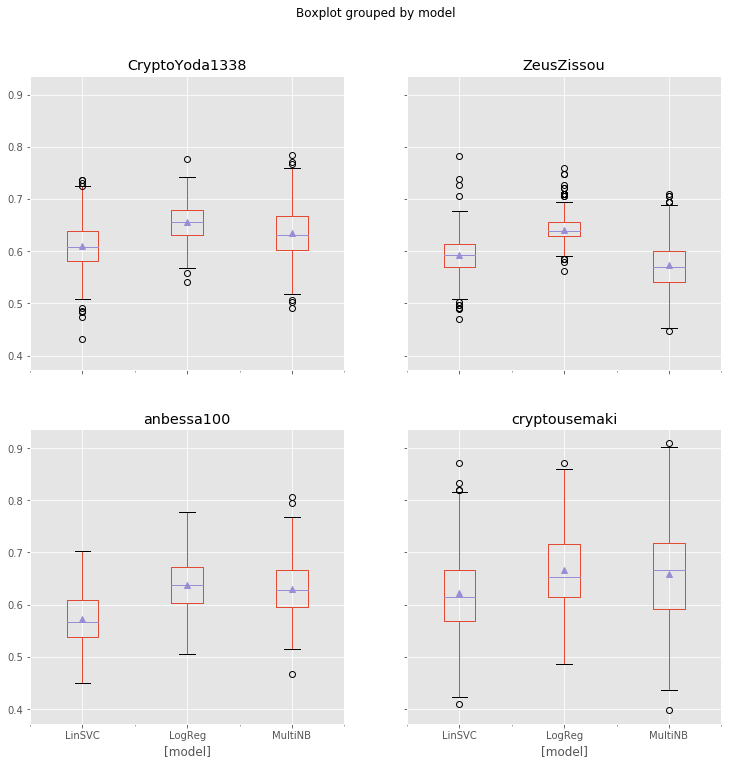

In [28]:
df_acc_res = get_all_scores(res_dict, 'full_test_accs')
df_acc_res.boxplot(by='model', figsize=(12,12), showmeans = True)

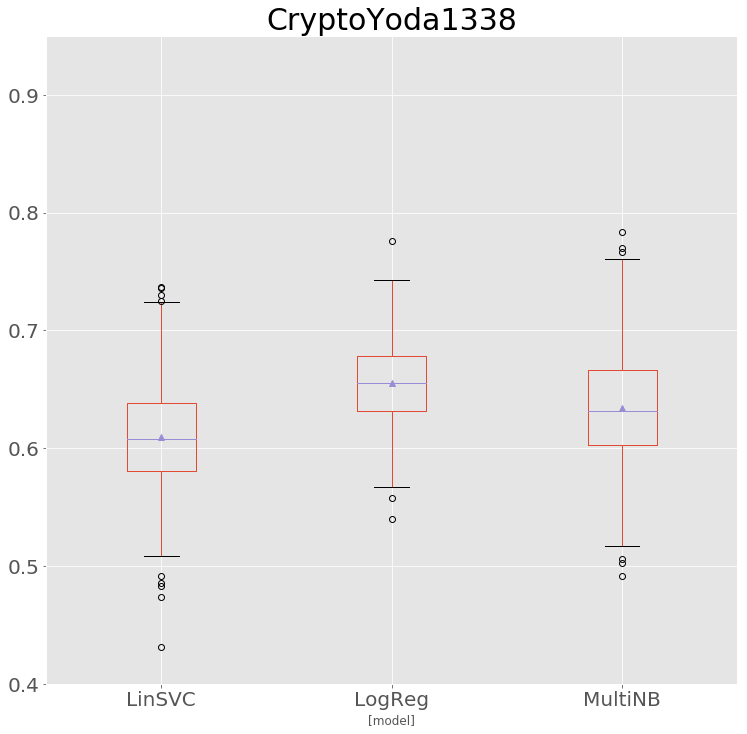

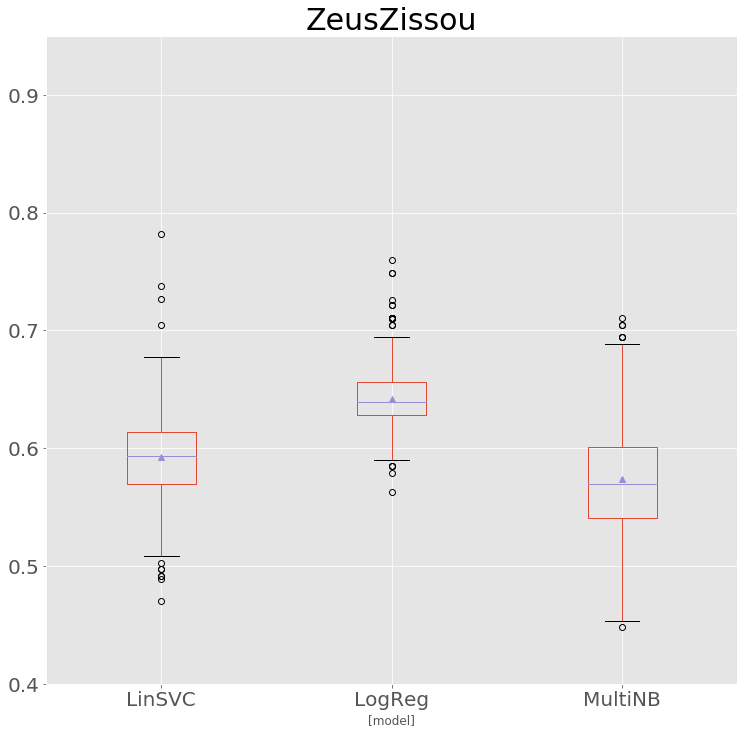

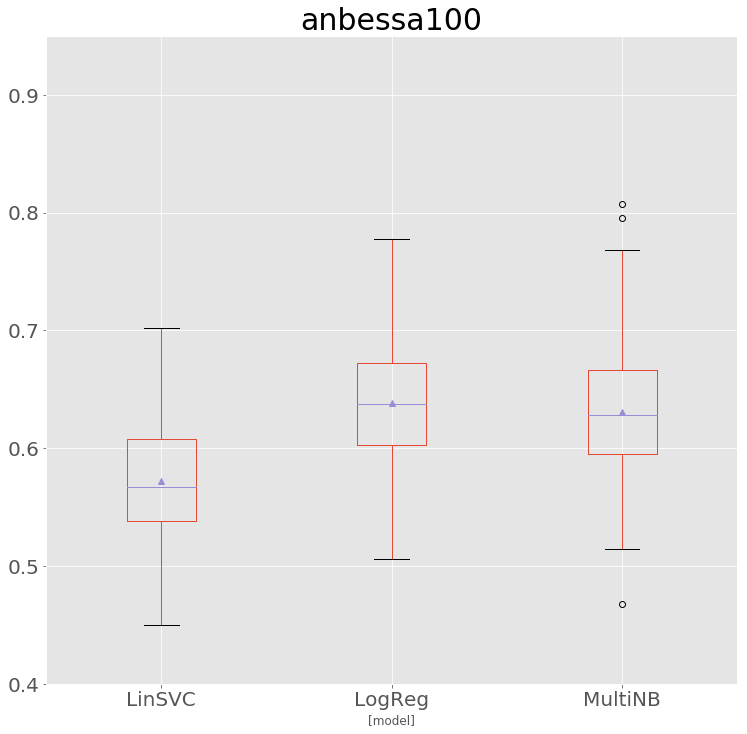

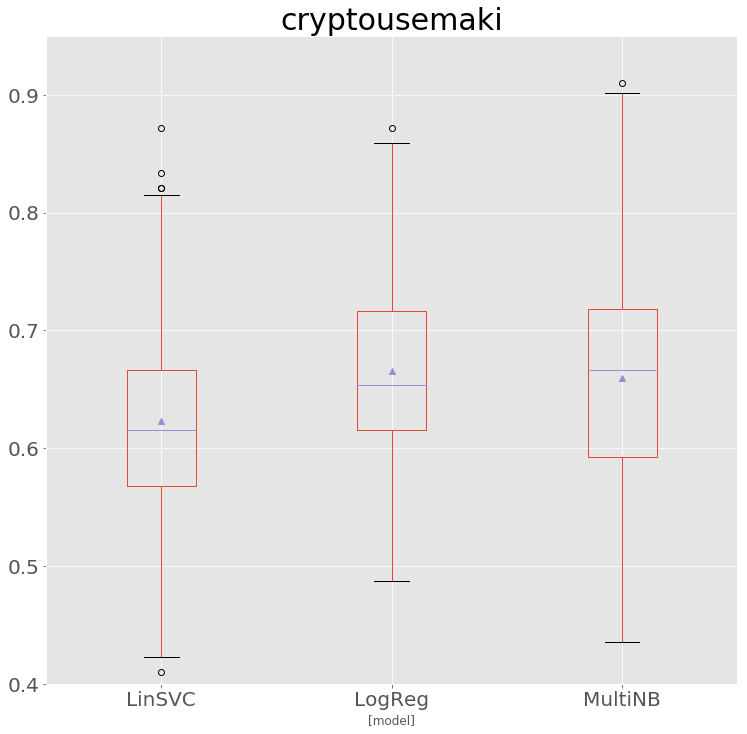

In [31]:
users =  all_tweets.user.unique()[1:5]

for user in sorted(list(users)):
    df = df_acc_res[['index',user,'model']]

    fig = plt.figure(figsize=(12,12))
    fig.subplots_adjust(top=0.9, wspace=0.3)

    ax = fig.add_subplot(1,1,1)
    df.boxplot(by = 'model', ax=ax, showmeans = True, fontsize= 30)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0.4,0.95)
    ax.title.set_size(30)
    fig.texts = [] #flush the old super titles
    fig.savefig('Accuracy Plots/' + 'app6_' + user)

### 4b) Information Gain

In [21]:
df_null_res = get_all_scores(res_dict, 'full_test_null_accs')

dict_res_test_ig = {}
dict_res_test_ig['model'] = df_acc_res['model']
for user in all_users[1:5]:
    test_ig = [df_acc_res[user][pos] - df_null_res[user][pos] for pos in range(len(df_acc_res))]
    dict_res_test_ig[user] = test_ig

df_test_ig = pd.DataFrame(dict_res_test_ig)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A3C9CEA9E8>,
      dtype=object)

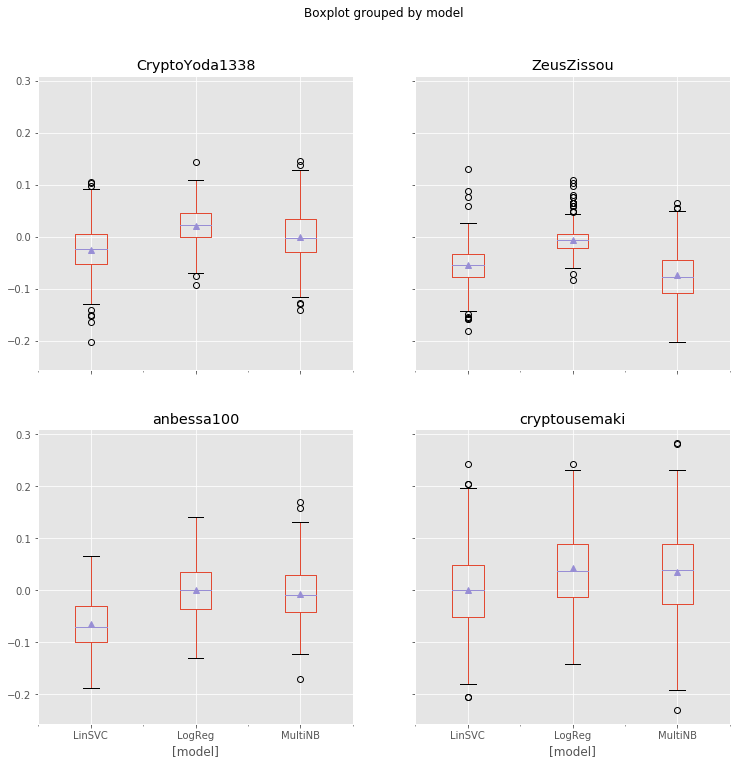

In [22]:
df_test_ig.boxplot(by='model', figsize=(12,12), showmeans = True)